<font size="10">Learning Global Linearizing Transformations with Koopman Eigenfunctions</font>

<font size="4">TBD.</font>

<font size="4">TBD.</font> 

<font size="4">This code was written by Jason J. Bramburger and accompanies the work in Section 6.3 of the book <i>Data-Driven Methods for Dynamic Systems</i>. We use Tensorflow 2.0 to build the neural network, which is imported as tf.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Henon Map
def map(x,lam1 = 1.5, lam2 = 0.4):
    
    xnp1 = [lam1*x[0], lam2*(x[1] - x[0]**2)]
    
    return xnp1

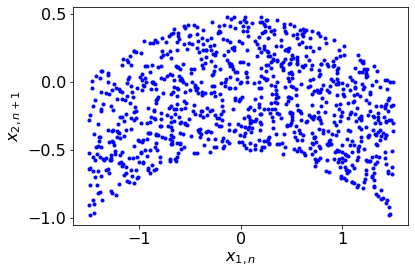

In [29]:
# Sample random points in the domain [-1,1]^2 and determine their image under map in previious block 

# Initializations
N = 1000 # number of samples
xn = np.zeros((N,2))
xnp1 = np.zeros((N,2))

# Map parameters
lam1 = 1.5
lam2 = 0.5

for n in range(1,N):
    xn[n] = 2*np.random.rand(2) - 1 
    xnp1[n] = map(xn[n], lam1, lam2) # forward iterate of the toy model map from Exercise 2.3.1

# Plot the image of the unit square under the map for visualization
plt.plot(xnp1[:,0],xnp1[:,1],'b.')
plt.xlabel('$x_{1,n}$',)
plt.ylabel('$x_{2,n+1}$')
plt.rc('font', size= 16)

In [58]:
# Conjugacy neural network architecture

from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

class Conjugacy(Model):
  def __init__(self,
                 width = 100,
                 size_x = 2,
                 size_y = 3,
                 activation = 'selu',
                 numblksIn = 1,
                 l1reg = 1e-15,
                 l2reg = 1e-15,
                 **kwargs):
    super(Conjugacy, self).__init__()
    self.width = width 
    self.size_x = size_x
    self.size_y = size_y
    self.activation = activation
    self.numblksIn = numblksIn
    self.l1reg = l1reg
    self.l2reg = l2reg
    self.initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)
    
    # Real-valued Koopman eigenvalues
    self.a1 = tf.Variable(1.5, trainable = False) 
    self.a2 = tf.Variable(0.5, trainable = False) 
    self.a3 = tf.Variable(2.25, trainable = False)
    
    # Encoder function 
    self.encoder = tf.keras.Sequential()
    
    for n in range(self.numblksIn): #adding more layers
        self.encoder.add(layers.Dense(width, activation=self.activation, 
                                      kernel_initializer=self.initializer, 
                                      kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                      bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    # Final layer to go to logistic map variables
    self.encoder.add(layers.Dense(self.size_y, activation=self.activation, 
                                  kernel_initializer=self.initializer,
                                  kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                  bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))

    # Decoder function: single layer linear output
    self.decoder = tf.keras.Sequential()
    self.decoder.add(tf.keras.layers.Dense(self.size_x, activation= tf.keras.activations.linear, 
                                           kernel_initializer=self.initializer, 
                                           kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                           bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    
  def call(self, x):
    encoded = self.encoder(x)
    
    # Build foward iterates under linear map
    y1np1 = self.a1*encoded[:,0]
    y2np1 = self.a2*encoded[:,1]
    y3np1 = self.a3*encoded[:,2]
    
    # Stack forward iterates of linear map back together
    encoded_p1 = tf.stack([y1np1, y2np1, y3np1], axis = -1)
    decoded = self.decoder(encoded_p1)
    
    # Encoder/Decoder loss
    x_recon = self.decoder(encoded)
    self.add_loss(tf.reduce_mean(tf.math.square(x - x_recon)))
    
    # f = rho of g of eta loss 
    xnp1_1 = lam1*x[:,0]
    xnp1_2 = lam2*(x[:,1] - tf.math.square(x[:,0]))
    xnp1 = tf.stack([xnp1_1, xnp1_2], axis = -1)
    self.add_loss(tf.reduce_mean(tf.math.square(decoded - xnp1)))
    
    # Linear map (g) loss
    xnp1_encoded = self.encoder(xnp1)
    self.add_loss(tf.reduce_mean(tf.math.square(encoded_p1 - xnp1_encoded)))
    
    return decoded

In [63]:
# Neural Network Parameters

width = 200 # width of each NN layer
size_x = 2 # number of variables in the original nonlinear map
size_y = 3 # number of variables in the linear Koopman map
activation = 'selu' # nonlinear activation function at each NN layer of the encoder
learning_rate = 0.000001
numblks_in = 5 # number of layers for the encoder NN

In [ ]:
conjugacy = Conjugacy(width, size_x, size_y, activation, numblks_in)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 200)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
conjugacy.compile(optimizer=optimizer, loss = 'mse') 

conjugacy.fit(xn, xnp1, callbacks = [callback], epochs = 5000, verbose = 1)

Epoch 1/5000
32/32 [==============================] - 1s 2ms/step - loss: 3.5446
Epoch 2/5000
32/32 [==============================] - 0s 2ms/step - loss: 3.1957
Epoch 3/5000
32/32 [==============================] - 0s 2ms/step - loss: 2.8901
Epoch 4/5000
32/32 [==============================] - 0s 2ms/step - loss: 2.6263
Epoch 5/5000
32/32 [==============================] - 0s 2ms/step - loss: 2.3993
Epoch 6/5000
32/32 [==============================] - 0s 2ms/step - loss: 2.2064
Epoch 7/5000
32/32 [==============================] - 0s 2ms/step - loss: 2.0431
Epoch 8/5000
32/32 [==============================] - 0s 2ms/step - loss: 1.9068
Epoch 9/5000
32/32 [==============================] - 0s 2ms/step - loss: 1.7926
Epoch 10/5000
32/32 [==============================] - 0s 2ms/step - loss: 1.6974
Epoch 11/5000
32/32 [==============================] - 0s 2ms/step - loss: 1.6180
Epoch 12/5000
32/32 [==============================] - 0s 2ms/step - loss: 1.5490
Epoch 13/5000
32/32 [====

In [61]:
# Print Discovered Eigenvalues
print('Discovered Koopman Eigenvalues (assumed real)')
print('---------------------------------------------')
print('a1 = ', conjugacy.a1.numpy())
print('a2 = ', conjugacy.a2.numpy())
print('a3 = ', conjugacy.a3.numpy())
print('')
print('True Koopman Eigenvalues')
print('------------------------')
print('a1 = ', lam1)
print('a2 = ', lam2)
print('a3 = ', lam1**2)
print('')
print('NOTE: Discovered eigenvalues may appear in a different order from the true values')

Discovered Koopman Eigenvalues (assumed real)
---------------------------------------------
a1 =  1.5
a2 =  0.5
a3 =  2.25

True Koopman Eigenvalues
------------------------
a1 =  1.5
a2 =  0.5
a3 =  2.25

NOTE: Discovered eigenvalues may appear in a different order from the true values


In [ ]:
# Output to MATLAB





In [62]:
# Save network config
#!mkdir -p saved_conjugacy_networks
conjugacy.save('saved_conjugacy_networks/global_linear_real_fixed') # For fixed eigenvalues
#conjugacy.save('saved_conjugacy_networks/global_linear_real_variable') # For variable eigenvlues

INFO:tensorflow:Assets written to: saved_conjugacy_networks/global_linear_real_fixed/assets


In [ ]:
# Load and view saved models

# Load fixed eigenvalues model
conjugacy = tf.keras.models.load_model('saved_conjugacy_networks/global_linear_real_fixed')

# Load variable eigenvalues model
#conjugacy = tf.keras.models.load_model('saved_conjugacy_networks/global_linear_real_fixed')

# Check eigenvalues
print('---------------------------------------------')
print('a1 = ', conjugacy.a1.numpy())
print('a2 = ', conjugacy.a2.numpy())
print('a3 = ', conjugacy.a3.numpy())
print('---------------------------------------------')

# Neural network summary
conjugacy.summary()

# Compile the network
conjugacy.compile()